# **hkl_soleil** E6C psi axis

Show how to set, compute, and scan $\psi$ with the E6C diffractometer
{ref}`geometry <geometries-hkl_soleil-e6c>`. Use the `hkl_soleil` solver.  Scan
{math}`\psi` at fixed {math}`Q` and {math}`hkl_2`.

Virtual axes, such as $\psi$, are features provided by the solver as *extras*.
*Extras* are not necessarily available in every solver.  Consult the solver
documentation for details.

---

**NOTE**

> **&#9432;**  The demonstrations below rely on features provided by the
> `hkl_soleil` solver.

---

## Concise Summary

- Define an E6C diffractometer object using `hkl` computation engine (the default).
- Add a sample.
- Add two known reflections, and compute its $UB$ matrix
- Set $\psi$
    - Use the `"psi_constant_vertical"` mode.
    - Make a dictionary with $hkl_2$ and $\psi$.
    - Finally, compute the real-space position at $hkl$.
- Compute $\psi$
    - Create a second E6C diffractometer object using the `"psi"` computation engine.
    - Copy the $UB$ matrix from the `e6c_hkl` diffractometer.
    - Set $hkl_2$.
      (Since these are simulators, copy the real-space motor positions.)
    - Show the position of $\psi$.
- Scan $\psi$
    - Run the diffractometer's custom `scan_extra()` plan,
      specifying both $hkl$ (as `pseudos`) and $hkl_2$ (as `extras`).

## Overview

To work with $\psi$ we'll use the `"hkl"` engine of the E6C [geometry](../diffractometers.rst). To compute
$\psi$ we'll use the `"psi"` engine.  This table summarizes our use:

engine | how it is used
--- | ---
`"hkl"` | work in reciprocal-space coordinates $h, k, l$
`"psi"` | compute the $\psi$ rotation angle (not for operations)

<!--
TODO: compare with APS POLAR geometry

See J. Appl. Cryst. (1999). 32, 943-950, https://doi.org/10.1107/S0021889899007347
"Angle calculations for a six-circle κ diffractometer"
G. Thorkildsen, R. H. Mathiesen and H. B. Larsen

Also, DLS has a K6C at I16
https://indico.psi.ch/event/12738/contributions/38939/attachments/22657/39873/NOBUGS2022_diffcalc_v2.pdf
-->

$\psi$ is the rotation of reference vector $hkl_2$ perpendicular to scattering
vector $Q$:

<img src="../_static/psi-angle.png" width="400" />

color | description
--- | ---
blue | incident and exit X-ray beams
green | scattering vector ($Q$)
red | reference vector ($hkl_2$)
yellow | rotation ($\psi$) from $hkl_2$ around $Q$
black | principle cartesian axes
gray | sample

### Steps

1. With the `"hkl"` engine:
    1. Orient a crystalline sample with the `"hkl"` engine.
    1. Define the azimuthal reflection $h_2, k_2, l_2$ and a $\psi$ rotation.
    1. Position the diffractometer for the $h, k, l$ reflection.
1. With the `"psi"` engine:
    1. Copy sample and orientation information from the `"hkl"` instance.
    1. Copy position information:
       - This step is necessary since this notebook uses *simulated* motors.
       - Diffractometers using EPICS motors will do this automatically.
    1. Compute `psi`.
    1. Compare the computed `psi` value with the value set with the `"hkl"` instance.
1. Scan $\psi$ at fixed $Q$ and $hkl_2$.

## Setup E6C Simulators

Create instances of (simulated) E6C for the `"hkl"` and `"psi"` solver engines.
The `hklpy2.creator()` function creates both.

In [1]:
import hklpy2

e6c_hkl = hklpy2.creator(
    name="e6c_hkl",
    geometry="E6C",
    solver="hkl_soleil",
    solver_kwargs={"engine": "hkl"},
)
e6c_psi = hklpy2.creator(
    name="e6c_psi",
    geometry="E6C",
    solver="hkl_soleil",
    solver_kwargs={"engine": "psi"},
)

Show the different calculation engines available for the E6C geometry.

In [2]:
print(f"{e6c_hkl.core.solver.engines=}")

e6c_hkl.core.solver.engines=['hkl', 'psi', 'q2', 'qper_qpar', 'tth2', 'incidence', 'emergence']


---

**NOTE**

> **&#9432;**  The `solver` works at a lower level than ophyd.  All the code and
> structures used by a solver are pure Python code (or calls from Python to
> lower level libraries.)

---

Show the different operation modes available with each engine for the E6C geometry.

The `hkl` engine has a `"psi_constant_vertical"` mode that can be used to calculate reals given some fixed parameters (UB, wavelength, $(hkl)$, $(hkl)_2$, $\psi$).  The `psi` engine has only one mode.

In [3]:
print(f"{e6c_hkl.core.modes=}")
print(f"{e6c_psi.core.modes=}")

e6c_hkl.core.modes=['bissector_vertical', 'constant_omega_vertical', 'constant_chi_vertical', 'constant_phi_vertical', 'lifting_detector_phi', 'lifting_detector_omega', 'lifting_detector_mu', 'double_diffraction_vertical', 'bissector_horizontal', 'double_diffraction_horizontal', 'psi_constant_vertical', 'psi_constant_horizontal', 'constant_mu_horizontal']
e6c_psi.core.modes=['psi_vertical']


Show the extra axes available with each mode used by this notebook.  (The extras
have default values at this time.)

The `psi` engine has a pseudo axis `"psi"` that can be used to calculate $\psi$ given some fixed parameters (reals, UB, wavelength, $(hkl)$, $(hkl)_2$)

In [4]:
e6c_hkl.core.mode = "bissector_vertical"
print(f"{e6c_hkl.core.mode=}")
print(f"{e6c_hkl.core.extras=}")

e6c_hkl.core.mode = "psi_constant_vertical"
print(f"{e6c_hkl.core.mode=}")
print(f"{e6c_hkl.core.extras=}")

# "psi" engine has only one mode, do not need to set it
print(f"{e6c_psi.core.mode=}")
print(f"{e6c_psi.core.extras=}")

e6c_hkl.core.mode='bissector_vertical'
e6c_hkl.core.extras={}
e6c_hkl.core.mode='psi_constant_vertical'
e6c_hkl.core.extras={'h2': 0, 'k2': 0, 'l2': 0, 'psi': 0}
e6c_psi.core.mode='psi_vertical'
e6c_psi.core.extras={'h2': 0, 'k2': 0, 'l2': 0}


### Define and orient a sample

The sample for this notebook is crystalline vibranium, with a cubic lattice of exactly $2\pi$.  With it mounted on oru diffractometer, we have identified two reflections which define its orientation.

In [5]:
import math

e6c_hkl.wavelength.put(1.54)  # angstrom (8.0509 keV)

e6c_hkl.add_sample("vibranium", 2 * math.pi, digits=5)

e6c_hkl.add_reflection((4, 0, 0), (0, 29.354, 0, 2, 0, 58.71), name="r400")
e6c_hkl.add_reflection((0, 4, 0), (0, 29.354, 0, 92, 0, 58.71), name="r040")
for r in e6c_hkl.sample.reflections.order:
    print(f"{e6c_hkl.sample.reflections[r]}")
e6c_hkl.core.calc_UB(*e6c_hkl.sample.reflections.order)

print(f"{e6c_hkl.sample.UB=!r}")
print(f"{e6c_hkl.sample.U=!r}")

Reflection(name='r400', h=4, k=0, l=0)
Reflection(name='r040', h=0, k=4, l=0)
e6c_hkl.sample.UB=[[0.034882054037, 0.999391435978, -0.0], [0.0, 0.0, 1.0], [0.999391435978, -0.034882054037, -0.0]]
e6c_hkl.sample.U=[[0.034882054037, 0.999391435978, 0.0], [0.0, 0.0, 1.0], [0.999391435978, -0.034882054037, 0.0]]


### Move to the $(111)$ orientation

Before moving the diffractometer, ensure you have selected the desired operating
*mode*.

In [6]:
e6c_hkl.core.mode = "bissector_vertical"
e6c_hkl.move(1, 0, 0)
e6c_hkl.position, e6c_hkl.real_position

(Hklpy2DiffractometerPseudoPos(h=1.00000000737, k=-8.2488e-08, l=0),
 Hklpy2DiffractometerRealPos(mu=0, omega=7.039252630487, chi=-2.512923e-06, phi=1.998994715295, gamma=0, delta=14.078505260974))

## Set ${hkl}_2$ and $\psi$

Show the extra axes available with `psi_constant_vertical` mode.

In [7]:
e6c_hkl.core.mode = "psi_constant_vertical"
print(f"{e6c_hkl.core.solver_extra_axis_names=}")

e6c_hkl.core.solver_extra_axis_names=['h2', 'k2', 'l2', 'psi']


Set azimuthal reflection ${hkl}_2 = (110)$ and $\psi=12$.

The `extras` are described as a Python dictionary with values for each of the parameters.

In [8]:
e6c_hkl.core.extras = dict(h2=1, k2=1, l2=0, psi=12)
print(f"{e6c_hkl.core.extras=}")

e6c_hkl.core.extras={'h2': 1, 'k2': 1, 'l2': 0, 'psi': 12}


Compute the real-axis motor values with the $Q=(111)$ reflection oriented and $\psi$ rotation.

In [9]:
p_111 = e6c_hkl.forward(1, 1, 1)
print(f"{p_111=}")

p_111=Hklpy2DiffractometerRealPos(mu=0, omega=113.608391926862, chi=80.226182466798, phi=130.002672432183, gamma=0, delta=-24.50984311379)


Move each real (real-space positioner) to the computed $(111)$ reflection position `p_111`.

In [10]:
e6c_hkl.move_reals(p_111)
print(f"{e6c_hkl.position=}")
print(f"{e6c_hkl.real_position=}")
print(f"{e6c_hkl.core.extras=}")

e6c_hkl.position=Hklpy2DiffractometerPseudoPos(h=0.999999999997, k=0.999999999998, l=1.000000000001)
e6c_hkl.real_position=Hklpy2DiffractometerRealPos(mu=0, omega=113.608391926862, chi=80.226182466798, phi=130.002672432183, gamma=0, delta=-24.50984311379)
e6c_hkl.core.extras={'h2': 1, 'k2': 1, 'l2': 0, 'psi': 12}


## Compute $\psi$ at fixed $Q$ and $hkl_2$

We'll use the `"psi"` engine to compute $\psi$, given a sample & orientation,
${hkl}_2$, and the real-space motor positions.

In [11]:
print(f"{e6c_psi.core.mode=}")
print(f"{e6c_psi.core.extras=}")

e6c_psi.core.mode='psi_vertical'
e6c_psi.core.extras={'h2': 0, 'k2': 0, 'l2': 0}


Same sample and lattice

In [12]:
e6c_psi.add_sample("vibranium", 2 * math.pi, digits=5)

Sample(name='vibranium', lattice=Lattice(a=6.28319, system='cubic'))

Copy orientation from `hkl` instance.  Note the `psi` and `hkl` UB matrices are
not exactly equal.  Equal to about 5 decimal places.)

In [13]:
e6c_psi.sample.UB = e6c_hkl.sample.UB

print(f"{e6c_psi.sample.UB=!r}")
print(f"{e6c_psi.sample.U=!r}")

print(f"{e6c_hkl.sample.UB=!r}")
print(f"{e6c_hkl.sample.U=!r}")

e6c_psi.sample.UB=[[0.034882054037, 0.999391435978, -0.0], [0.0, 0.0, 1.0], [0.999391435978, -0.034882054037, -0.0]]
e6c_psi.sample.U=[[1, 0, 0], [0, 1, 0], [0, 0, 1]]
e6c_hkl.sample.UB=[[0.034882054037, 0.999391435978, -0.0], [0.0, 0.0, 1.0], [0.999391435978, -0.034882054037, -0.0]]
e6c_hkl.sample.U=[[0.034882054037, 0.999391435978, 0.0], [0.0, 0.0, 1.0], [0.999391435978, -0.034882054037, 0.0]]


Set ${hkl}_2=(1, 1, 0)$.  As above, describe these parameters in a Python dictionary.

In [14]:
e6c_psi.core.extras = dict(h2=1, k2=1, l2=0)
print(f"{e6c_psi.core.extras=}")

e6c_psi.core.extras={'h2': 1, 'k2': 1, 'l2': 0}


Set real-space axis positions from `p_111` (above).

In [15]:
e6c_psi.move_reals(p_111)
print(f"{e6c_psi.pseudo_axis_names=}")
print(f"{e6c_psi.core.solver_pseudo_axis_names=}")
print(f"{e6c_psi.position=}")
print(f"{e6c_psi.real_position=}")

e6c_psi.pseudo_axis_names=['psi']
e6c_psi.core.solver_pseudo_axis_names=['psi']
e6c_psi.position=Hklpy2DiffractometerPseudoPos(psi=11.999985086114)
e6c_psi.real_position=Hklpy2DiffractometerRealPos(mu=0, omega=113.608391926862, chi=80.226182466798, phi=130.002672432183, gamma=0, delta=-24.50984311379)


Compare `hkl` and `psi` reports.

In [16]:
print(e6c_hkl)
e6c_hkl.wh()
print(e6c_psi)
e6c_psi.wh()

Hklpy2Diffractometer(prefix='', name='e6c_hkl', settle_time=0.0, timeout=None, egu='', limits=(0, 0), source='computed', read_attrs=['h', 'h.readback', 'h.setpoint', 'k', 'k.readback', 'k.setpoint', 'l', 'l.readback', 'l.setpoint', 'mu', 'omega', 'chi', 'phi', 'gamma', 'delta'], configuration_attrs=['solver_signature', 'wavelength', 'h', 'k', 'l'], concurrent=True)
h=1.0, k=1.0, l=1.0
wavelength=1.54
mu=0, omega=113.6084, chi=80.2262, phi=130.0027, gamma=0, delta=-24.5098
h2=1 k2=1 l2=0 psi=12
Hklpy2Diffractometer(prefix='', name='e6c_psi', settle_time=0.0, timeout=None, egu='', limits=(0, 0), source='computed', read_attrs=['psi', 'psi.readback', 'psi.setpoint', 'mu', 'omega', 'chi', 'phi', 'gamma', 'delta'], configuration_attrs=['solver_signature', 'wavelength', 'psi'], concurrent=True)
psi=12.0
wavelength=1.0
mu=0, omega=113.6084, chi=80.2262, phi=130.0027, gamma=0, delta=-24.5098
h2=1 k2=1 l2=0


## Scan $\psi$ at fixed $Q$ and $hkl_2$

Setup the bluesky tools needed to run scans and review data.

In [17]:
import databroker

from bluesky import RunEngine
from bluesky.callbacks.best_effort import BestEffortCallback
from ophyd.sim import noisy_det

from hklpy2 import ConfigurationRunWrapper

# Save orientation of the diffractometer.
crw = ConfigurationRunWrapper(e6c_hkl)

bec = BestEffortCallback()
bec.disable_plots()
cat = databroker.temp().v2
RE = RunEngine()
RE.subscribe(cat.v1.insert)
RE.subscribe(bec)
RE.preprocessors.append(crw.wrapper)

Scan $\psi$ over a wide range in coarse steps.

---

**NOTE**

> **&#9432;**  Since $\psi$ is an *extra* axis, it is only available with
> certain operation modes, such as `"psi_constant_vertical"`.  Be sure to set
> that before scanning.  The plan will raise a `KeyError` if the axis name is
> not recognized.  Any extra axes are not ophyd objects since they are defined
> only when certain modes are selected.  A custom plan is provided which scans
> an extra axis, while holding any pseudos or reals, and other extras at
> constant values.

---

This example chooses $Q=(002)$ and $hkl_2=(120)$. (The reference $hkl_2$
was chosen to be perpendicular to $Q$.)  Save the `uid` from the scan for later
reference.

To control the solution space, we adjust the low limit of both $\varphi$ and
$\omega$ so their ranges are limited to $0..180^o$.

The `e6c_hkl` diffractometer is added as a detector here so that all the
positioner values will be available for plotting later.

In [18]:
e6c_hkl.core.mode = "psi_constant_vertical"
e6c_hkl.core.constraints["phi"].low_limit = 0
e6c_hkl.core.constraints["omega"].low_limit = 0
(uid,) = RE(
    e6c_hkl.scan_extra(
        [noisy_det, e6c_hkl],
        axis="psi",
        start=0,
        finish=150,
        num=15,
        pseudos=dict(h=0, k=0, l=2),
        extras=dict(h2=1, k2=2, l2=0),
    ),
)



Transient Scan ID: 1     Time: 2025-04-02 18:42:05
Persistent Unique Scan ID: 'dd55a11f-8669-4fff-85d8-a82bbd22a970'
New stream: 'primary'
+-----------+------------+------------+------------+------------+------------+---------------+-------------+-------------+---------------+---------------+------------+--------------------+
|   seq_num |       time |  e6c_hkl_h |  e6c_hkl_k |  e6c_hkl_l | e6c_hkl_mu | e6c_hkl_omega | e6c_hkl_chi | e6c_hkl_phi | e6c_hkl_gamma | e6c_hkl_delta |  noisy_det | e6c_hkl_extras_psi |
+-----------+------------+------------+------------+------------+------------+---------------+-------------+-------------+---------------+---------------+------------+--------------------+
|         1 | 18:42:05.8 |     -0.000 |      0.000 |      2.000 |          0 |       165.812 |      90.000 |     155.434 |             0 |       -28.375 |      1.063 |              0.000 |
|         2 | 18:42:05.8 |      0.000 |      0.000 |      2.000 |          0 |       165.812 |      90.

### Plot any motions

The only real-space axis to be moved by this scan is $\varphi$.  Plot $\phi$ *vs.*
$\psi$.

axis | data name
--- | ---
$\varphi$ | `e6c_hkl_phi`
$\psi$ | `e6c_hkl_extras_psi`
---

**NOTE**

> **&#9432;**  *Extra* axes are named with the `_extras` label inserted in the
> name.

---


/home/prjemian/.conda/envs/hklpy2/lib/python3.13/site-packages/databroker/intake_xarray_core/base.py:23: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


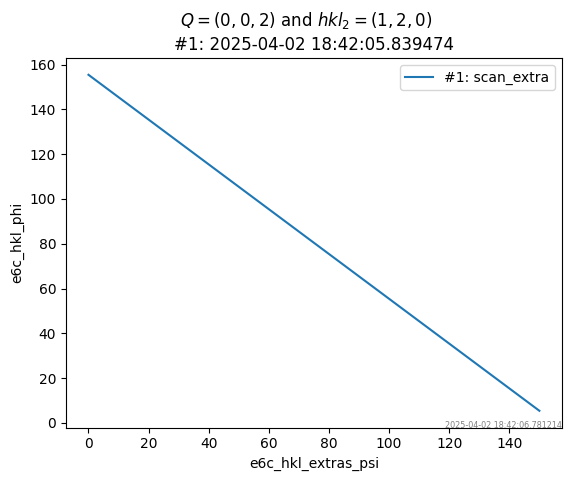

In [19]:
from apstools.utils import plotxy

run = cat[uid]

# Compose a title from current conditions.
pos = e6c_hkl.full_position(digits=0)
Q = f"({pos['h']:.0f}, {pos['k']:.0f}, {pos['l']:.0f})"
hkl2 = f"({pos['h2']:.0f}, {pos['k2']:.0f} ,{pos['l2']:.0f})"
title = f"$Q={Q}$ and $hkl_2={hkl2}$"

plotxy(run, "e6c_hkl_extras_psi", "e6c_hkl_phi", stats=False, title=title)